In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from scipy.stats import norm
from scipy.stats import beta
from scipy.stats import uniform
from scipy.special import factorial

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
sns.set_theme(palette="colorblind")

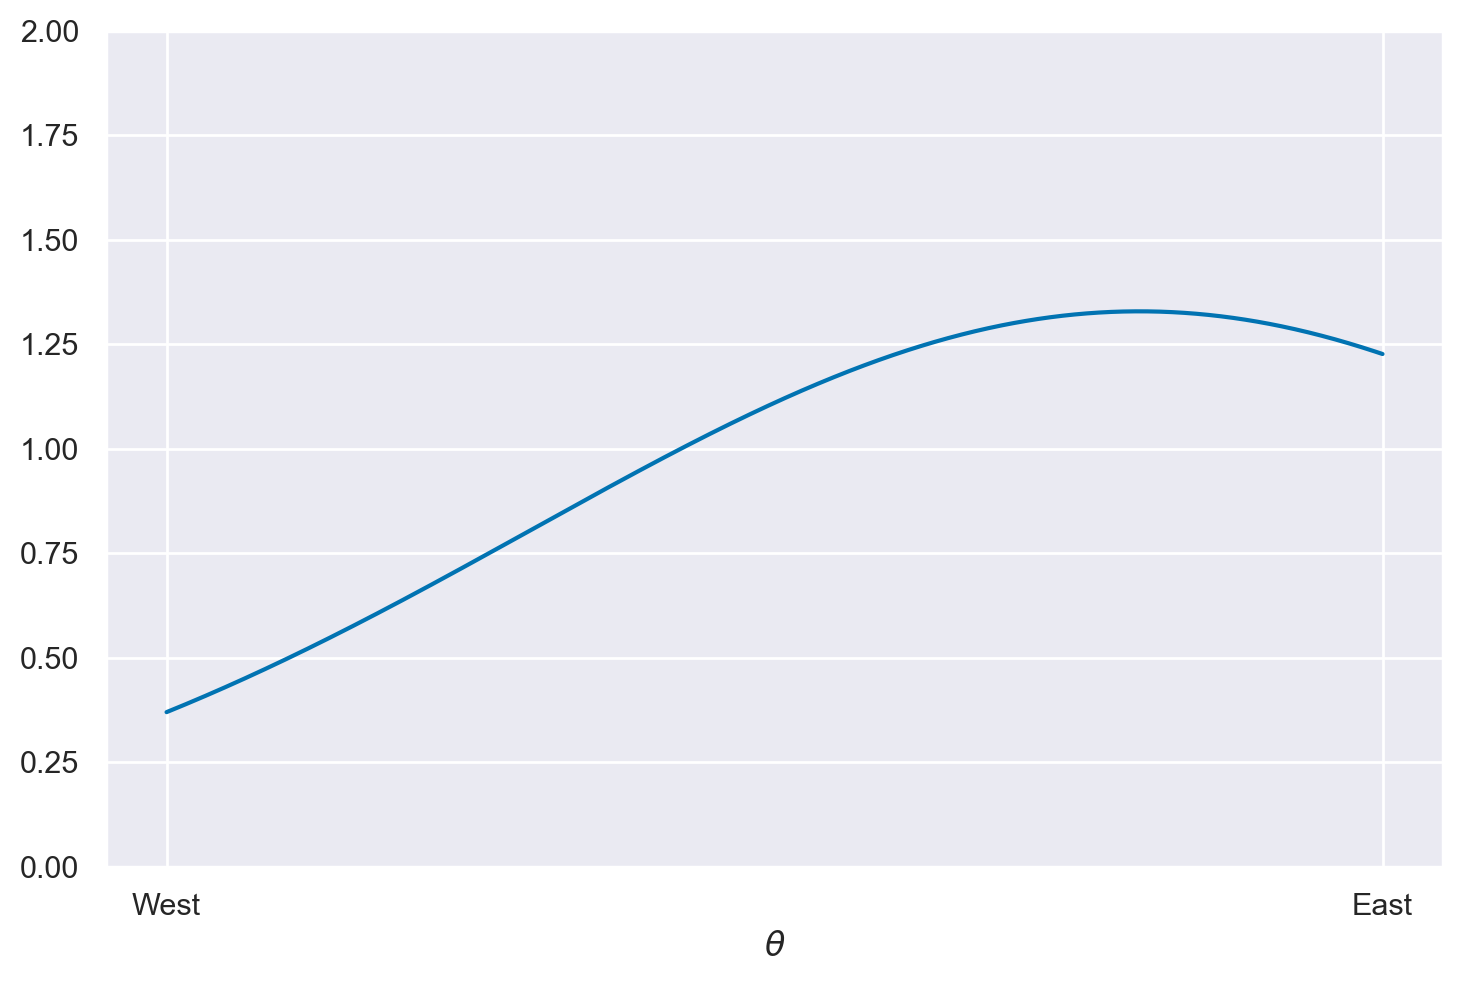

In [3]:
def dnorm_trunc(x, mean=0, sd=1, ll=0, ul=1):
    out = norm.pdf(x, mean, sd) / (norm.cdf(ul, mean, sd) - norm.cdf(ll, mean, sd))
    out[(x > ul) | (x < ll)] = 0
    return out

# Data points for x-axis
x_vals = np.linspace(0, 1, 1000)

# Parameters for the dnorm_trunc function
mean_val = 0.8
sd_val = 0.5

# Calculate the y values using dnorm_trunc function
y_vals = dnorm_trunc(x_vals, mean_val, sd_val)

# Plot the curve
plt.plot(x_vals, y_vals)
plt.ylim(0, 2)
plt.xlabel(r"$\theta$")
plt.ylabel("")
plt.xticks([0, 1], ["West", "East"])
plt.show()

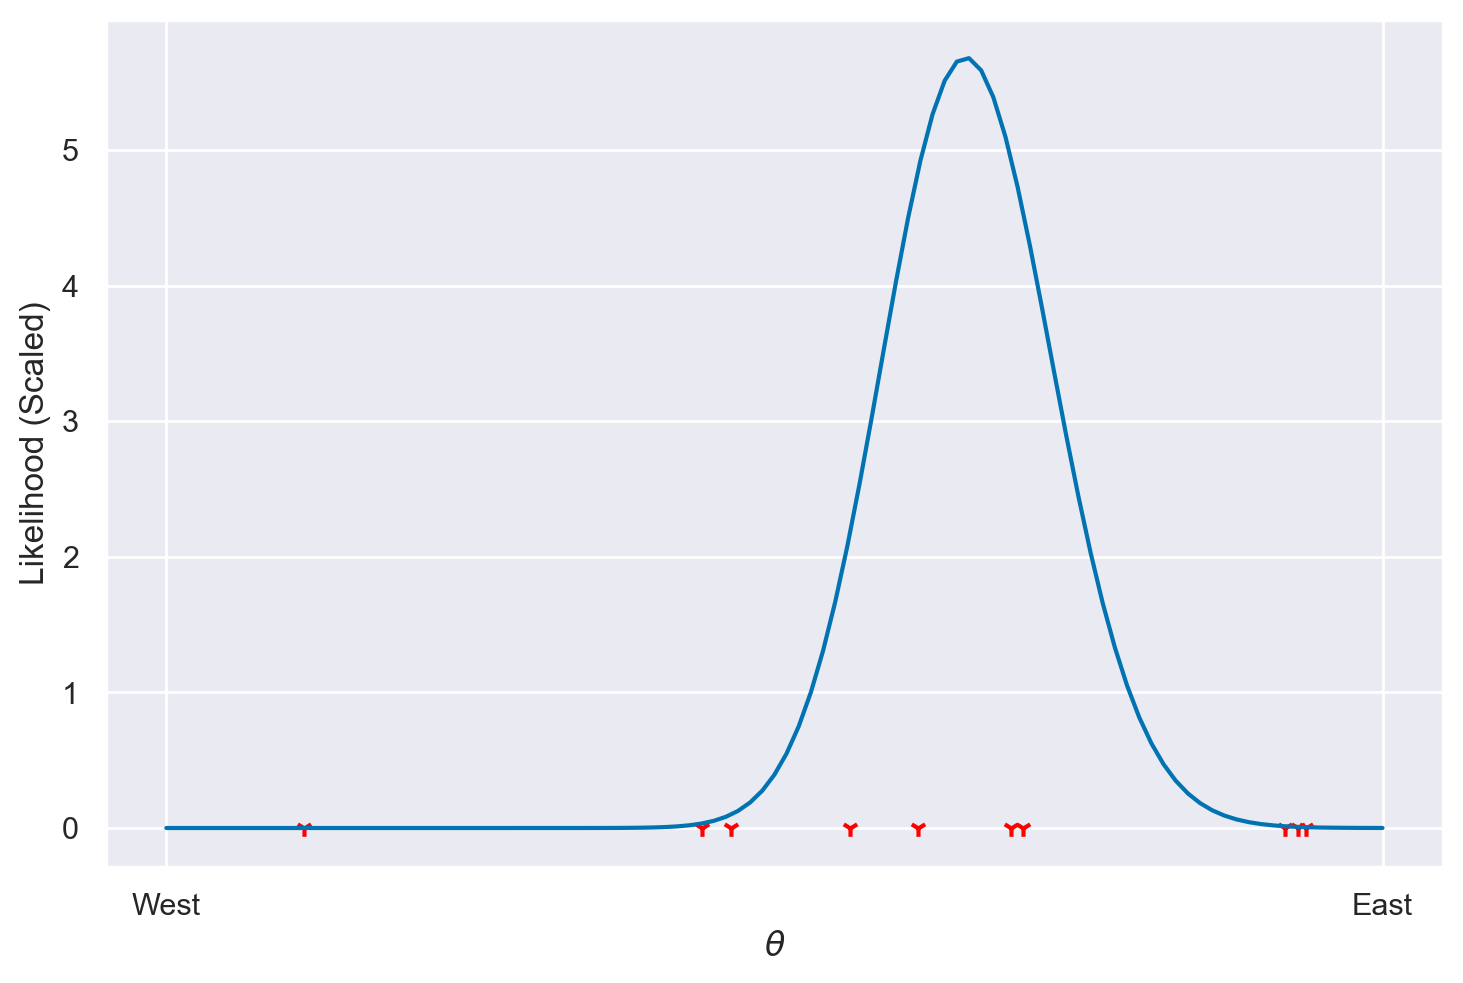

In [4]:
def qnorm_trunc(p, mean=0, sd=1, ll=0, ul=1):
    cdf_ll = norm.cdf(ll, loc=mean, scale=sd)
    cdf_ul = norm.cdf(ul, loc=mean, scale=sd)
    return norm.ppf(cdf_ll + p * (cdf_ul - cdf_ll), loc=mean, scale=sd)


def rnorm_trunc(n, mean=0, sd=1, ll=0, ul=1):
    p = np.random.uniform(size=n)
    return qnorm_trunc(p, mean=mean, sd=sd, ll=ll, ul=ul)


grid = np.linspace(0, 1, num=101)


def compute_lik(x, pts=grid, sd=0.2, binwidth=0.01):
    lik_vals = norm.pdf(x[:, np.newaxis], loc=pts, scale=sd) / (
        norm.cdf(1, loc=pts, scale=sd) - norm.cdf(0, loc=pts, scale=sd)
    )
    lik = np.prod(lik_vals, axis=0)
    return lik / np.sum(lik) / binwidth


np.random.seed(4)
dat_x = rnorm_trunc(10, mean=0.6, sd=0.2)
lik_x = compute_lik(dat_x)

plt.plot(grid, lik_x)
plt.scatter(dat_x, np.zeros_like(dat_x), color="red", marker="1")
plt.xlabel(r"$\theta$")
plt.ylabel("Likelihood (Scaled)")
plt.xticks([0, 1], ["West", "East"])
plt.show()

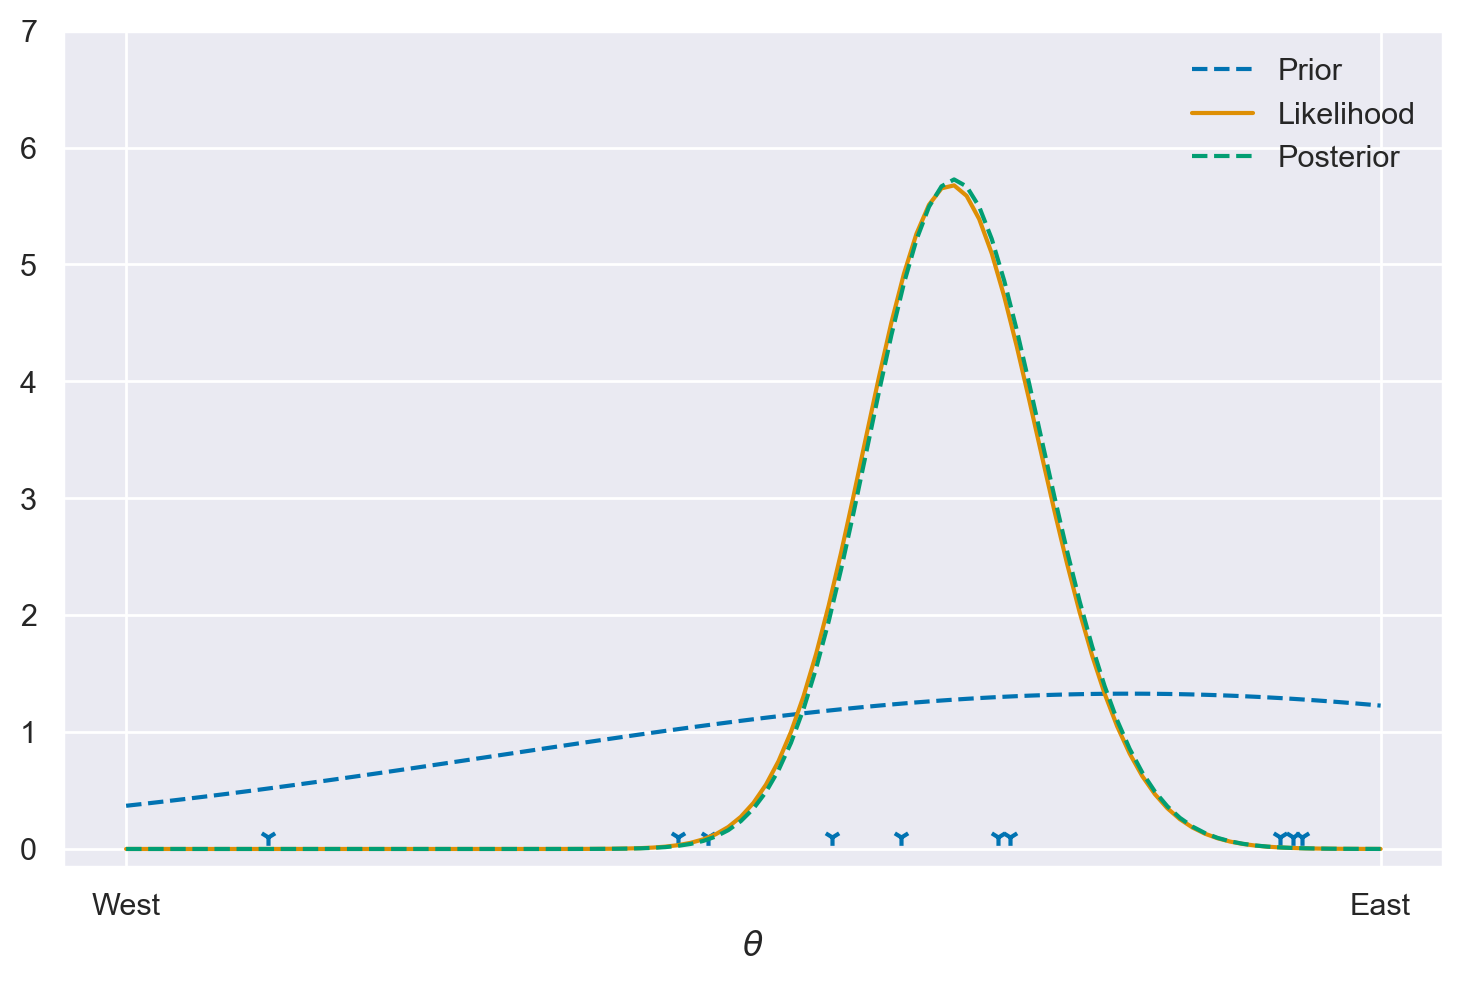

In [5]:
def update_probs(prior_probs, lik, binwidth=0.01):
    post_probs = prior_probs * lik
    return post_probs / np.sum(post_probs) / binwidth

grid = np.linspace(0, 1, num=101)

# Prior probabilities
prior_probs = dnorm_trunc(grid, mean=0.8, sd=0.5)

# Likelihood values
lik_x = compute_lik(dat_x)

# Posterior probabilities
posterior_probs = update_probs(prior_probs, lik_x)

# Plotting
plt.plot(grid, dnorm_trunc(grid, mean=0.8, sd=0.5), linestyle='dashed', label='Prior')
plt.plot(grid, lik_x, linestyle='solid', label='Likelihood')
plt.plot(grid, posterior_probs, linestyle='dashed', label='Posterior')
plt.scatter(dat_x, np.zeros_like(dat_x)+.1, marker='1')
plt.ylim(-0.15, 7)
plt.xlabel(r'$\theta$')
plt.ylabel('')
plt.xticks([-0, 1], ["West", "East"])
plt.legend()
plt.show()

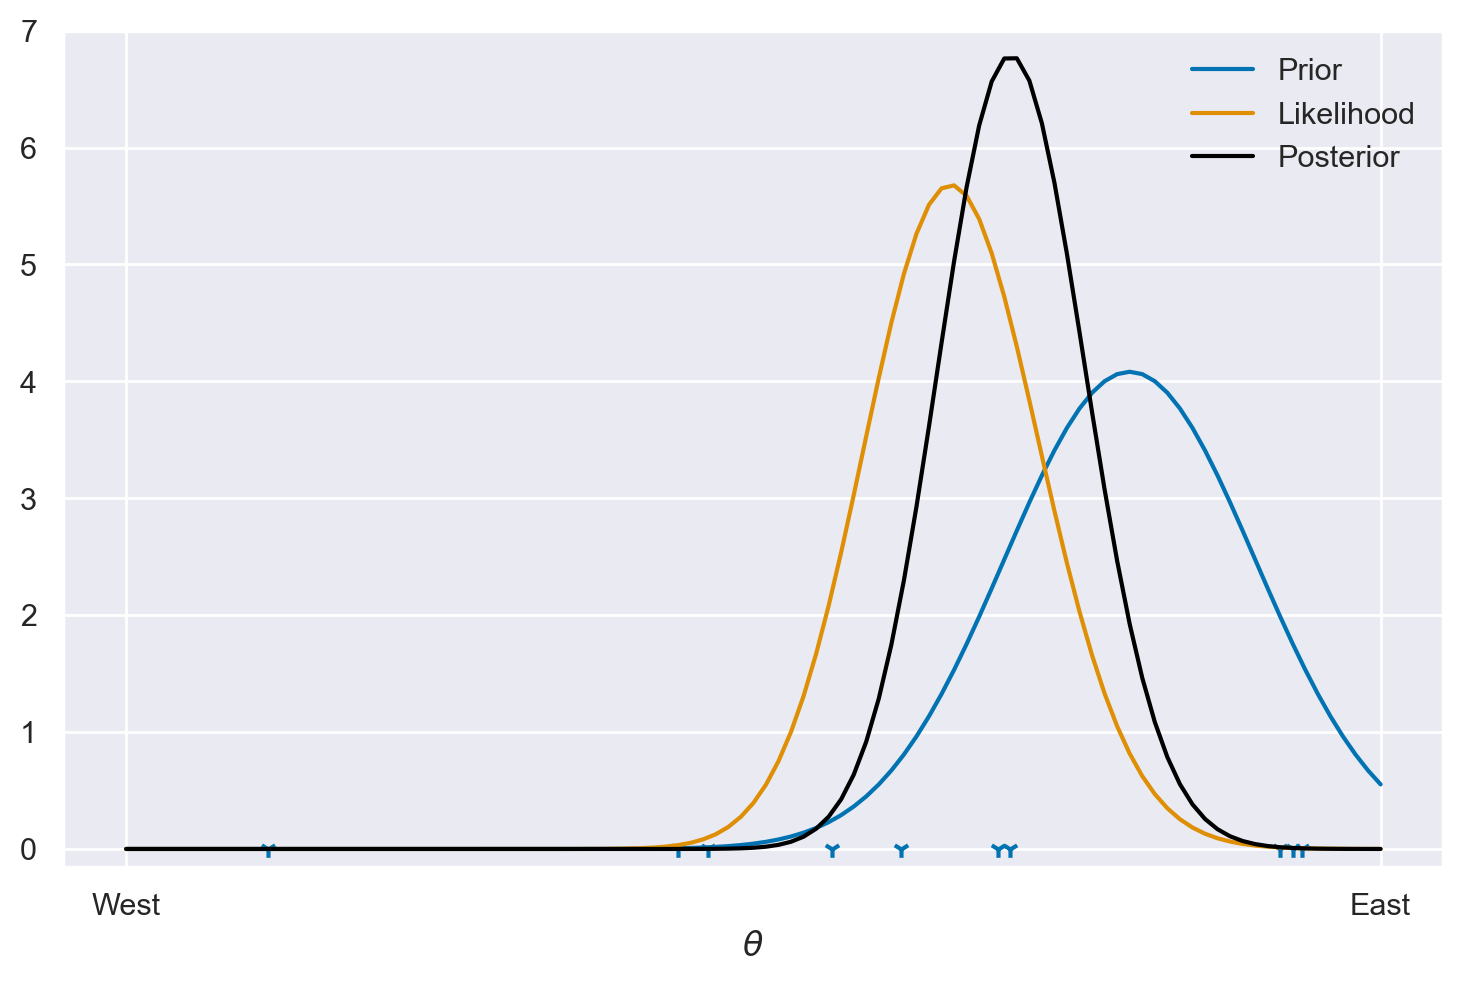

In [6]:
grid = np.linspace(0, 1, num=101)

# Prior probabilities
prior_probs = dnorm_trunc(grid, mean=0.8, sd=0.1)

# Likelihood values
lik_x = compute_lik(dat_x)

# Posterior probabilities
posterior_probs = update_probs(prior_probs, lik_x)

# Plotting
plt.plot(grid, dnorm_trunc(grid, mean=0.8, sd=0.1), label='Prior')
plt.plot(grid, lik_x, linestyle='solid', label='Likelihood')
plt.plot(grid, posterior_probs, color='black', label='Posterior')
plt.scatter(dat_x, np.zeros_like(dat_x), marker='1')
plt.ylim(-0.15, 7)
plt.xlabel(r'$\theta$')
plt.ylabel('')
plt.xticks([0, 1], ["West", "East"])
plt.legend()
plt.show()

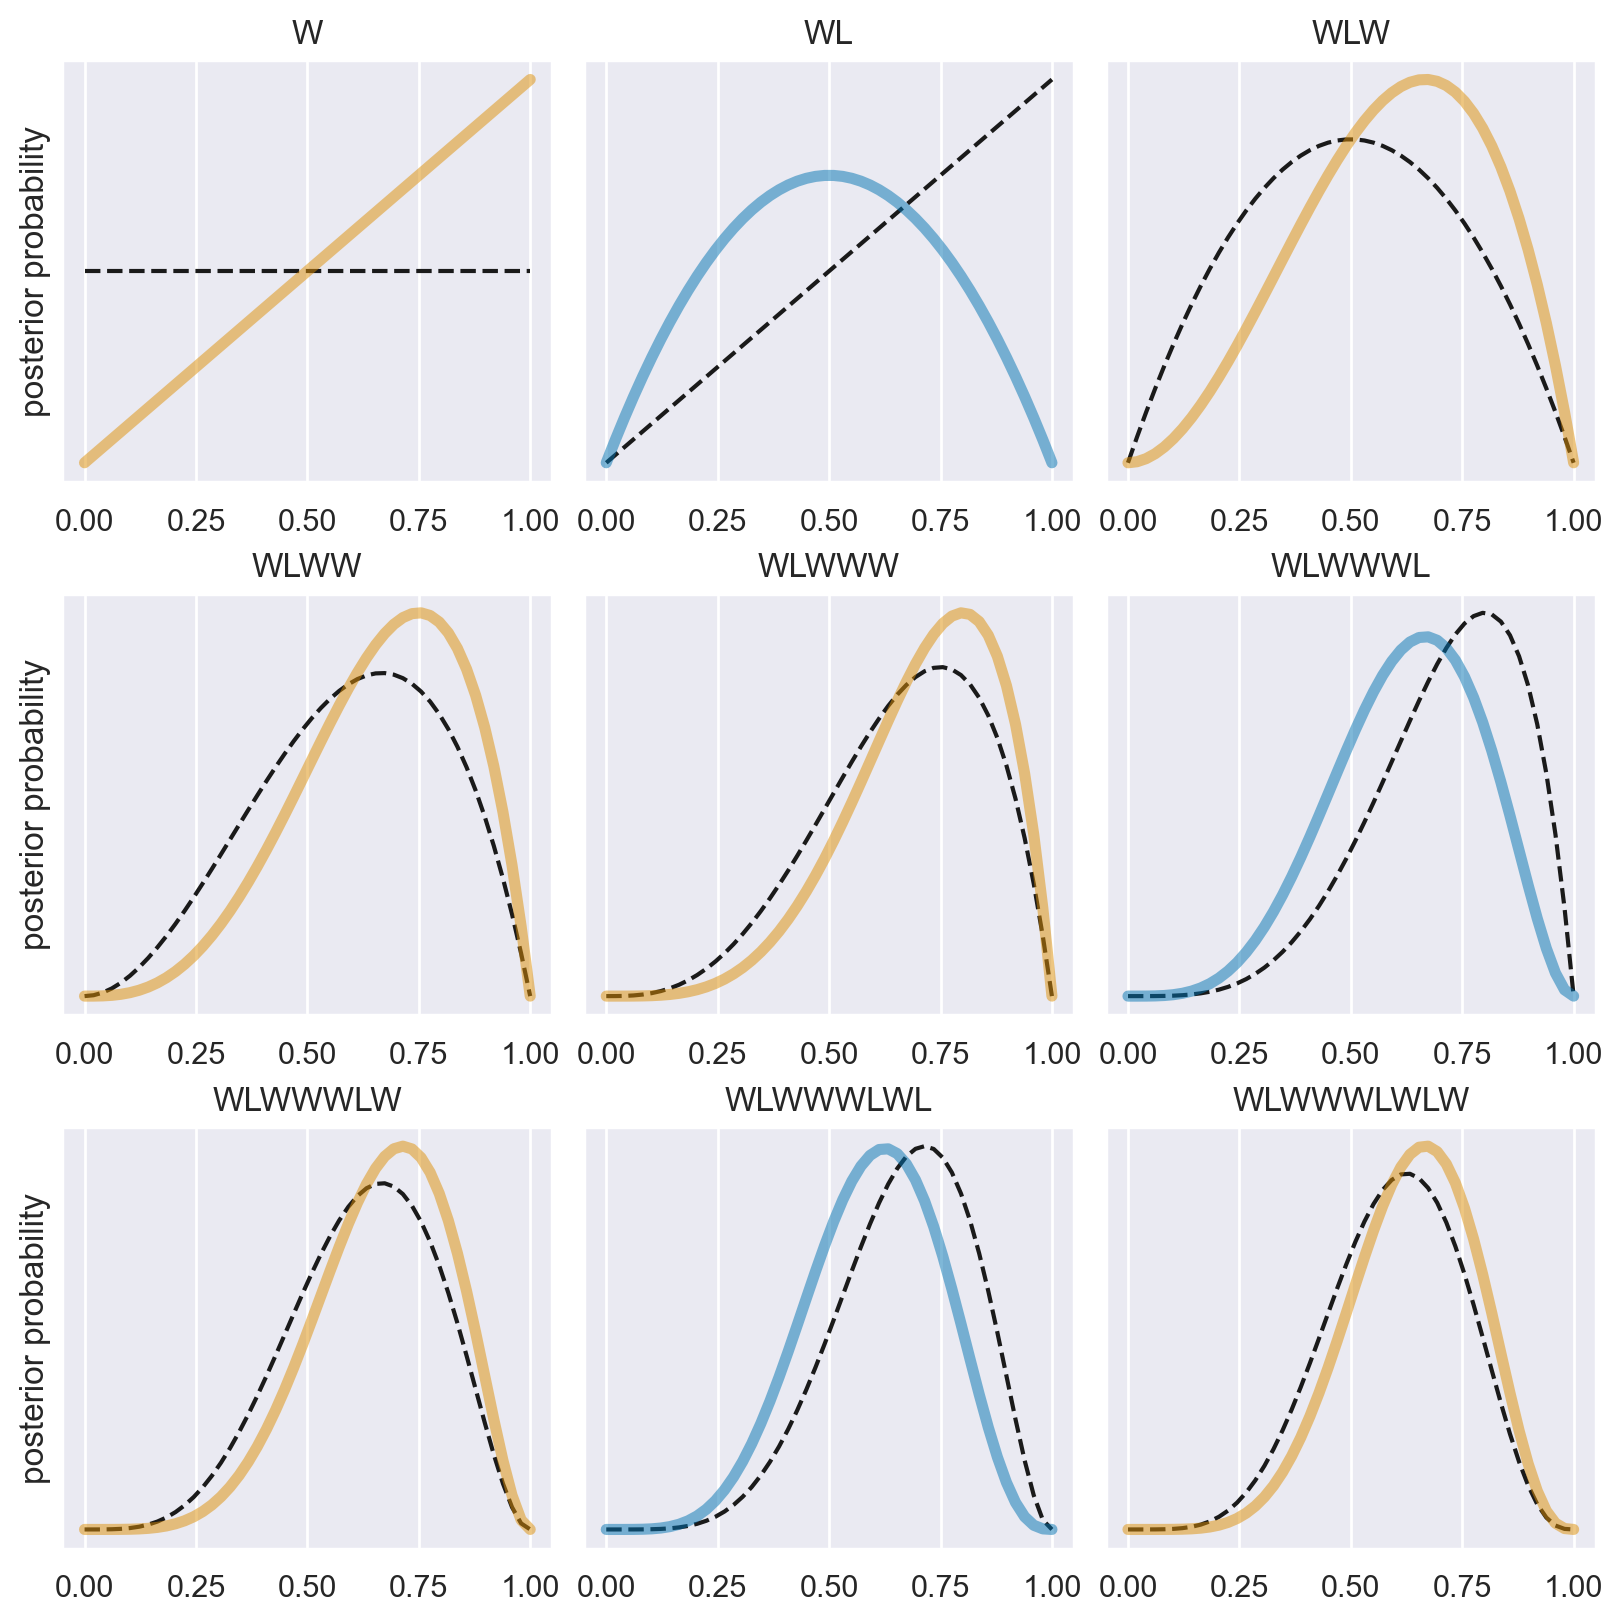

In [7]:
def beta(W, L, p):
    return factorial(W + L + 1) / (factorial(W) * factorial(L)) * p ** W * (1-p) ** L


def plot_beta_from_observations(observations: str, resolution: int = 50, **plot_kwargs):
    """Calcualte the posterior for a string of observations"""
    n_W = len(observations.replace("L", ""))
    n_L = len(observations) - n_W
    proportions = np.linspace(0, 1, resolution)
        
    probs = beta(n_W, n_L, proportions)
    plt.plot(proportions, probs, **plot_kwargs)
    plt.yticks([])
    plt.title(observations)
    

# Tossing the globe
observations = "WLWWWLWLW"
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
for ii in range(9):
    ax = axs[ii // 3][ii % 3]
    plt.sca(ax)
    # Plot previous
    if ii > 0:
        plot_beta_from_observations(observations[:ii], color='k', linestyle='--')
    else:
        # First observation, no previous data
        plot_beta_from_observations('', color='k', linestyle='--')
        
    color = 'C1' if observations[ii] == 'W' else 'C0'
    plot_beta_from_observations(observations[:ii+1], color=color, linewidth=4, alpha=.5)
    
    if not ii % 3:
        plt.ylabel("posterior probability")